In [59]:
%%html
<style>
.CodeMirror pre {
    font-family: "Ubuntu Mono", monospace;
    font-size: 12pt;
}
</style>

In [ ]:
# this is the script i used to generate ground truths in form of graphs
# from binary masks
# i shall not try to clean it up since, these has been meant to be run just once
# and since the dataset is pretty unique and will not be released publically
# and the results seem ok for as much as they were verified (also in this script)

In [1]:
import cv2
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
from graph_routines import graph_from_3D_mask, detectAndRemoveClusters, cycleBasis, reduceCycleBasis, minCycleBasis, verifyEdges
import scipy.sparse.csgraph as g
from skimage.morphology import skeletonize_3d
import pickle

def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
def showCube(vol):
    v1=np.max(vol,axis=0)
    v2=np.max(vol,axis=1)
    v3=np.max(vol,axis=2)
    imshow(v1*255)
    imshow(v2*255)
    imshow(v3*255)
def show2Cubes(vol1,vol2):
    v11=np.max(vol1,axis=0)
    v12=np.max(vol1,axis=1)
    v13=np.max(vol1,axis=2)
    v21=np.max(vol2,axis=0)
    v22=np.max(vol2,axis=1)
    v23=np.max(vol2,axis=2)
    imshow(np.concatenate([v11,v21],1)*255)
    imshow(np.concatenate([v12,v22],1)*255)
    imshow(np.concatenate([v13,v23],1)*255)
    
def show3Cubes(vol1,vol2,vol3):
    v11=np.max(vol1,axis=0)
    v12=np.max(vol1,axis=1)
    v13=np.max(vol1,axis=2)
    v21=np.max(vol2,axis=0)
    v22=np.max(vol2,axis=1)
    v23=np.max(vol2,axis=2)
    v31=np.max(vol3,axis=0)
    v32=np.max(vol3,axis=1)
    v33=np.max(vol3,axis=2)
    imshow(np.concatenate([v11,v21,v31],1)*255)
    imshow(np.concatenate([v12,v22,v32],1)*255)
    imshow(np.concatenate([v13,v23,v33],1)*255)
    
def show4Cubes(vol1,vol2,vol3,vol4):
    v11=np.max(vol1,axis=0)
    v12=np.max(vol1,axis=1)
    v13=np.max(vol1,axis=2)
    v21=np.max(vol2,axis=0)
    v22=np.max(vol2,axis=1)
    v23=np.max(vol2,axis=2)
    v31=np.max(vol3,axis=0)
    v32=np.max(vol3,axis=1)
    v33=np.max(vol3,axis=2)
    v41=np.max(vol4,axis=0)
    v42=np.max(vol4,axis=1)
    v43=np.max(vol4,axis=2)
    imshow(np.concatenate([v11,v21,v31,v41],1)*255)
    imshow(np.concatenate([v12,v22,v32,v42],1)*255)
    imshow(np.concatenate([v13,v23,v33,v43],1)*255)

In [2]:
from graph_routines import detectAndRemoveClusters, cycleBasis, reduceCycleBasis, minCycleBasis, verifyEdges

In [4]:
imgdir="/cvlabsrc1/cvlab/datasets_leo/neurons_tabea/orig/img/train"
lbldir="/cvlabsrc1/cvlab/datasets_leo/neurons_tabea/orig/lbl/train"
testimgdir="/cvlabsrc1/cvlab/datasets_leo/neurons_tabea/orig/img/test"
testlbldir="/cvlabsrc1/cvlab/datasets_leo/neurons_tabea/orig/lbl/test"
exec(open("testFiles_tabea.txt").read())
exec(open("trainFiles_tabea.txt").read())

In [6]:
datadir="/cvlabsrc1/cvlab/datasets_leo/neurons_tabea/orig/"
graphdir=os.path.join(datadir,"lbl_graph")
#os.mkdir(graphdir)
traingraphdir=os.path.join(graphdir,"train")
#os.mkdir(traingraphdir)
testgraphdir=os.path.join(graphdir,"test")
#os.mkdir(testgraphdir)

In [7]:
def removeCycle(edges,cycle):
    nodes_cycle=np.nonzero(cycle.reshape(edges.shape))[0]
    for k in nodes_cycle:
        if edges[k].sum()<3: # not connected to the outside of the cycle
            return k,True
    return 0,False

def removeCycles(edges,cycles):
    nodes= np.array(range(edges.shape[0]))
    nodes_to_be_removed=[]
    succ = True
    for c in cycles:
        print("attempting to remove cycle length",c.sum())
        n,res=removeCycle(edges,c)
        if res:
            print("succeeded")
        else:
            print("failed")
        succ=succ and res
        if res:
            nodes_to_be_removed.append(n)
    edges=np.delete(edges,nodes_to_be_removed,axis=0)
    edges=np.delete(edges,nodes_to_be_removed,axis=1)
    nodes=np.delete(nodes,nodes_to_be_removed,axis=0)
    return edges,nodes,succ
            

In [8]:
# check for single dangling nodes
def checkDangling(edges):
    dangling=[]
    singlyConnected=np.nonzero(edges.sum(1)==1)[0]
    for k in singlyConnected:
        nb=np.argmax(edges[k]).item()
        if edges[nb].sum()>2:
            #print("dangling node")
            dangling.append(k)
    return np.array(dangling)

def removeDangling(edges,nodes):
    k=0
    while k<edges.shape[0]:
        if edges[k].sum()==1:
            # k is singly connected
            nb=np.argmax(edges[k]).item()
            if edges[nb].sum()>2:
                # the only neighbor of k is multiply connected
                # so k is a dangling node
                edges=np.delete(edges,(k),0)
                edges=np.delete(edges,(k),1)
                nodes=np.delete(nodes,(k),0)
                continue
        k=k+1
    return edges,nodes
        

In [32]:
import sys
sys.path.append("/home/citraro/projects/topoloss4neurons/topo_score")
from toolong_tooshort_score import create_graph_3d

f = trainFiles[0]

lbl = tiff.imread(os.path.join(lbldir,f[1])) # (z,y,x) [0,1]

#img = img.transpose((1,3,2,0)) # (3,x,y,z)
lbl = lbl.transpose((2,1,0))  # (x,y,z) [0,1]

graph = create_graph_3d(lbl)

In [56]:
graph = create_graph_3d(lbl)

nodes_dict = {}
for i, pos in enumerate(graph.nodes()):
    nodes_dict[pos] = i

n_nodes = len(graph.nodes())
edges = np.zeros((n_nodes,n_nodes), np.bool)

for pos1,pos2 in graph.edges():
    s = nodes_dict[pos1]
    t = nodes_dict[pos2]
    edges[s-1,t-1] = True
    edges[t-1,s-1] = True
print(edges.shape)    
    
inds = np.int64([graph.nodes.data()[i]['pos'] for i in graph.nodes()])
print(inds.shape)

(23753, 23753)
(23753, 3)


In [74]:
def removeACluster(edges,nodes,cluster):
    
    # check if we can find a node that can be removed without altering the connectivity
    border=list(np.nonzero(edges[np.array(cluster)])[1])
    print("--")
    for n in cluster:
        print(n)
        #start = time.time()
        cluster_n=cluster.copy()
        cluster_n.remove(n)
        #print("1",time.time()-start)
        border_n=list(np.nonzero(edges[np.array(cluster_n)])[1])
        #print("2",time.time()-start)
        if set(border_n)==set(border): # remove the node
            #edges=np.delete(edges,(n),axis=0)
            #edges=np.delete(edges,(n),axis=1)
            edges[n,:] = False
            edges[:,n] = False
            nodes[n] = -1
            #nodes=np.delete(nodes,(n),axis=0)
            #print("3",time.time()-start)
            cluster.remove(n)
            #print("4",time.time()-start)
            return edges,nodes
    # if no node can be removed, try removing edges
    # make sure you do not diisconnect the border - true as long as in a cluster
    # make sure you do not leave a single dangling voxel - true because remove node would have removed a cluster node that would be dangling after edge removal
    # make sure you are not creating a cycle - ok, because the cycles will be clusters too
    # so you can remove any edge
    edges[cluster[0],cluster[1]]=0
    edges[cluster[1],cluster[0]]=0
  
    return edges,nodes

def detectAndRemoveACluster(edges,nodes):
    ncluster = 0

    #for k in np.where(nodes>0)[0]:
    for k in range(len(nodes)):    
        
        if nodes[k] == -1:
            continue
        
        cluster=[k]
        last_added=[k]
        while len(last_added)>0:
            candidates=list(np.nonzero(edges[np.array(last_added)])[1])
            last_added=[]
            while len(candidates)>0:
                c=candidates.pop()
                if c in cluster:
                    continue
                if np.all(edges[c][np.array(cluster)]):
                    cluster.append(c)
                    last_added.append(c)
    
        if len(cluster)>2: #found a cluster!
            edges,nodes=removeACluster(edges,nodes,cluster)
            #return edges,nodes,True
            ncluster+=1
    
    return edges,nodes,ncluster 

def detectAndRemoveClusters(edges,nodes=None):
    nodes=nodes if nodes else np.array(range(edges.shape[0]))
    res=True
    #while res:
    edges,nodes,ncluster=detectAndRemoveACluster(edges,nodes)
    print("there were {} clusters".format(ncluster))
        
    nodes = nodes[np.where(nodes>0)]
    edges = edges[nodes,:]
    edges = edges[:,nodes]   
        
    return edges,nodes 

In [154]:
from skimage.external import tifffile as tiff

# prepare graphs for training ground truths
graphs=[]
for f in trainFiles:
    
    print("Load gt label...")
    print(f)
    #img=np.load(os.path.join(imgdir,f[0])).astype(np.float32)
    #lbl=np.load(os.path.join(lbldir,f[1])).astype(np.float32)


    #img = tiff.imread(os.path.join(imgdir,f[0])) # (z,3,y,x) [0..255]
    lbl = tiff.imread(os.path.join(lbldir,f[1])) # (z,y,x) [0,1]

    #img = img.transpose((1,3,2,0)) # (3,x,y,z)
    lbl = lbl.transpose((2,1,0))  # (x,y,z) [0,1]

    lbl=skeletonize_3d(lbl)
    '''
    #showCube(lbl)
    inds,edges,d2=graph_from_3D_mask(lbl)
    '''
    print("Create initial graph...")
    graph = create_graph_3d(lbl)

    nodes_dict = {}
    inds = []
    for i, pos in enumerate(graph.nodes()):
        nodes_dict[pos] = i
        inds.append(pos)

    n_nodes = len(graph.nodes())
    edges = np.zeros((n_nodes,n_nodes), np.bool)

    for pos1,pos2 in graph.edges():
        s = nodes_dict[pos1]
        t = nodes_dict[pos2]
        edges[s,t] = True
        edges[t,s] = True    

    inds = np.int64(inds)    
    inds = inds[:,[1,0,2]]
    
    
    print("Detect and remove clusters...")
    '''
    edges_nc,nodes_nc=detectAndRemoveClusters(edges)
    inds_nc=inds[nodes_nc]
    #imshow(edges_nc.astype(np.uint8)*255)
    lbl_nc=np.zeros_like(lbl)
    '''
    edges_nc = edges
    inds_nc = inds
    
    '''
    for k in range(inds_nc.shape[0]):
        lbl_nc[inds_nc[k][0],inds_nc[k][1],inds_nc[k][2]]=1
    show2Cubes(lbl_nc,lbl)
    
    cycles_nc=minCycleBasis(edges_nc)
    if len(cycles_nc)>0:
        print("number cycles in the processed graph ",len(cycles_nc))
        print("Cremove cycles...")
        edges_rc,nodes_rc,res=removeCycles(edges_nc,cycles_nc)
        inds_nc=inds_nc[nodes_rc]
        edges_nc=edges_rc
        if not res:
            print("failed to remove a cycle")
            break
    
    if not verifyEdges(edges_nc,inds_nc):
        print("connection between non-neighboring voxels")
        #break

    num_cc_nc, component_labels_nc=g.connected_components(edges_nc)
    lbl_color_nc=np.zeros_like(lbl)
    for k in range(inds_nc.shape[0]):
        lbl_color_nc[inds_nc[k][0],inds_nc[k][1],inds_nc[k][2]]=component_labels_nc[k]+1
    lbl_color_nc=lbl_color_nc/float(num_cc_nc+1)
    #showCube(lbl_color_nc)
    #print( num_cc_nc )
    num_cc, component_labels=g.connected_components(edges)
    lbl_color=np.zeros_like(lbl)
    for k in range(edges.shape[0]):
        lbl_color[inds[k][0],inds[k][1],inds[k][2]]=component_labels[k]+1
    lbl_color=lbl_color/float(num_cc+1)
    show2Cubes(lbl_color,lbl_color_nc)
    #print( num_cc )
    if num_cc != num_cc_nc:
        print("different number of connected components")
        break
    assert(edges_nc.shape[0]==inds_nc.shape[0])
    '''
    graphs.append([f,edges_nc,inds_nc])

Load gt label...
['acq_2_crop_scaled.tif', 'acq_2_label_final.tif']
Create initial graph...
Detect and remove clusters...


In [124]:
edges_nc = edges
inds_nc = inds

In [107]:
import networkx as nx

graph = create_graph_3d(lbl) 

nodes_dict = {}
inds = []
for i, pos in enumerate(graph.nodes()):
    nodes_dict[pos] = i
    inds.append(pos)

n_nodes = len(graph.nodes())
edges_nc = np.zeros((n_nodes,n_nodes), np.bool)

for pos1,pos2 in graph.edges():
    s = nodes_dict[pos1]
    t = nodes_dict[pos2]
    edges_nc[s,t] = True
    edges_nc[t,s] = True    

inds = np.int64(inds)    
inds_nc = inds[:,[1,0,2]]


graph = nx.Graph()
for i,pos in enumerate(inds_nc):
    graph.add_node(i, pos=np.array(pos[[1,0,2]]))
    
for s,t in zip(*np.where(edges_nc)):
    graph.add_edge(s,t)

In [180]:
graph = nx.Graph()
for i,pos in enumerate(inds_nc):
    graph.add_node(i, pos=np.array(pos[[1,0,2]]))
    
for s,t in zip(*np.where(edges_nc)):
    graph.add_edge(s,t)

<IPython.core.display.Javascript object>


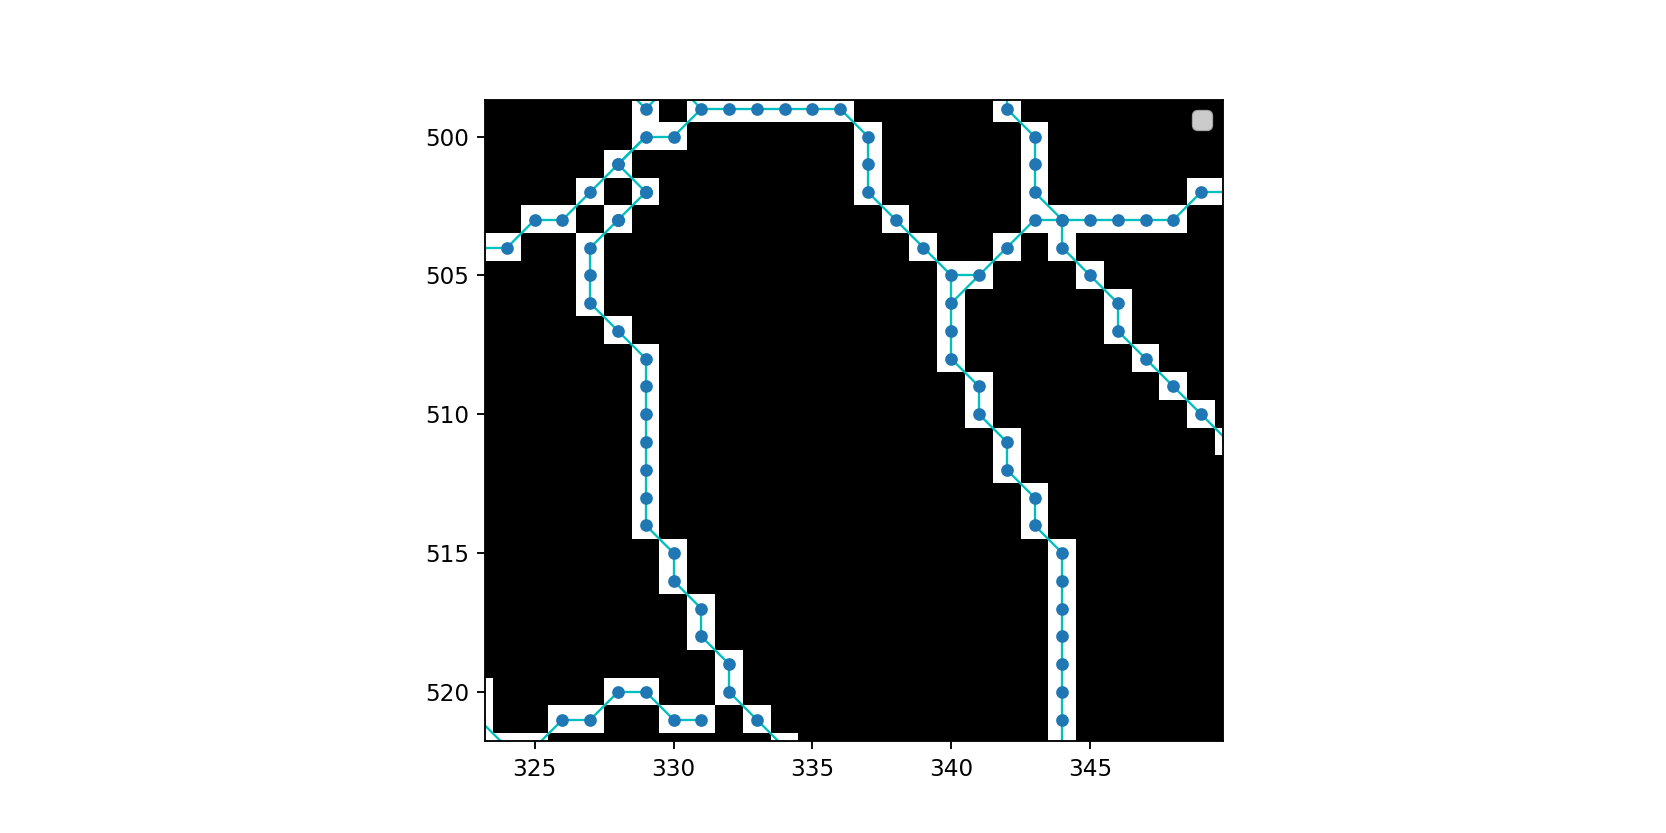

/home/citraro/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
No handles with labels found to put in legend.


In [181]:
def plot_graph(graph, node_size=200, font_size=6, 
               matched=[], false_pos=[], false_neg=[], 
               node_color=None, edge_color='c', **kwargs):

    pos = dict({i:graph.nodes.data()[i]['pos'][:2] for i in graph.nodes()})
    nx.draw_networkx(graph, pos=pos, node_size=node_size, node_color=node_color,
                     edge_color=edge_color, **kwargs)
    plt.gca().invert_yaxis()
    plt.legend()
    
#graph = create_graph_3d(lbl)    

plt.figure(figsize=(10,5))
plot_graph(graph, with_labels=False, edgelist=None, node_size=20)
plt.imshow(lbl.max(2))

In [168]:
np.sqrt(1.42**2+1.42**2)

2.0081832585697947

In [170]:
from scipy.spatial.distance import cityblock

In [182]:
for s,t in graph.edges():
    node1 = graph.nodes.data()[s]['pos']
    node2 = graph.nodes.data()[t]['pos']
    if np.any(np.abs(node1-node2)>=2):
        print(node1, node2, np.abs(node1-node2))
        #edges_nc[s,t] = False
        #edges_nc[t,s] = False

In [173]:
np.abs(node1-node2)>=2

array([False, False, False])

In [12]:
# here you can check the graphs some more....

In [184]:
graphs = [[f,edges_nc,inds_nc]]
# save training ground truth graphs
for gr in graphs:
    ff=open(os.path.join(traingraphdir,gr[0][1]),"bw")
    gt={'edges':gr[1],'node_coordinates':gr[2]}
    pickle.dump(gt,ff)
    ff.close()

In [ ]:
# prepare graphs for test ground truths
graphs=[]
for f in testFiles:
  print(f)
  img=np.load(os.path.join(testimgdir,f[1])).astype(np.float32)
  lbl=np.load(os.path.join(testlbldir,f[1])).astype(np.float32)
  #img=np.copy(img[:,0:100,0:100,0:100])
  #lbl=np.copy(lbl[0:100,0:100,0:100])
  #lbl[lbl<2]=0
  #lbl=lbl/2
  lbl_skeletonized=skeletonize_3d(lbl)
  #showCube(lbl)
  inds,edges,d2=graph_from_3D_mask(lbl)
    
    
    
  #imshow(edges.astype(np.uint8)*255)
  edges_nc,nodes_nc=detectAndRemoveClusters(edges)
  inds_nc=inds[nodes_nc]
  #imshow(edges_nc.astype(np.uint8)*255)
  lbl_nc=np.zeros_like(lbl)
  for k in range(inds_nc.shape[0]):
    lbl_nc[inds_nc[k][0],inds_nc[k][1],inds_nc[k][2]]=1
  show2Cubes(lbl_nc,lbl)
  cycles_nc=minCycleBasis(edges_nc)
  if len(cycles_nc)>0:
    print("number cycles in the processed graph ",len(cycles_nc))
    edges_rc,nodes_rc,res=removeCycles(edges_nc,cycles_nc)
    inds_nc=inds_nc[nodes_rc]
    edges_nc=edges_rc
    if not res:
        print("failed to remove a cycle")
        break
  if not verifyEdges(edges_nc,inds_nc):
    print("connection between non-neighboring voxels")
    break
  num_cc_nc, component_labels_nc=g.connected_components(edges_nc)
  lbl_color_nc=np.zeros_like(lbl)
  for k in range(inds_nc.shape[0]):
    lbl_color_nc[inds_nc[k][0],inds_nc[k][1],inds_nc[k][2]]=component_labels_nc[k]+1
  lbl_color_nc=lbl_color_nc/float(num_cc_nc+1)
  #showCube(lbl_color_nc)
  #print( num_cc_nc )
  num_cc, component_labels=g.connected_components(edges)
  lbl_color=np.zeros_like(lbl)
  for k in range(edges.shape[0]):
    lbl_color[inds[k][0],inds[k][1],inds[k][2]]=component_labels[k]+1
  lbl_color=lbl_color/float(num_cc+1)
  show2Cubes(lbl_color,lbl_color_nc)
  #print( num_cc )
  if num_cc != num_cc_nc:
    print("different number of connected components")
    break
  assert(edges_nc.shape[0]==inds_nc.shape[0])
  graphs.append([f,edges_nc,inds_nc])

In [ ]:
# check the graphs...

In [ ]:
# save the graphs for test ground truths
for gr in graphs:
    ff=open(os.path.join(testgraphdir,gr[0][0]),"bw")
    gt={'edges':gr[1],'node_coordinates':gr[2]}
    pickle.dump(gt,ff)
    ff.close()

In [ ]:
# read the graphs and remove dangling nodes

files=[trainFiles, testFiles]
lbldirs=[lbldir,testlbldir]
gdirs=[traingraphdir,testgraphdir]
for fls,lds,gd in zip(files,lbldirs,gdirs):
    print(lds)
    for f in fls:
        print(f)
        ff=open(os.path.join(gd,f[1]),"rb")
        gt=pickle.load(ff)
        ff.close()
        nc=gt['node_coordinates']
        edges_graph=gt['edges']
        dangling=checkDangling(edges_graph)
        print("before removal, there were {} dangling nodes".format(len(dangling)))
        edges_graph,nc=removeDangling(edges_graph,nc)
        dangling=checkDangling(edges_graph)
        print("after removal, there were {} dangling nodes".format(len(dangling)))
        ff=open(os.path.join(gd,f[1]),"bw")
        gt={'edges':edges_graph,'node_coordinates':nc}
        pickle.dump(gt,ff)
        ff.close()


In [ ]:
# verify the saved data: both test and train graphs
def colorComponents(lbl,edges,coords):
    lbl_=np.zeros_like(lbl)
    num_cc, component_labels=g.connected_components(edges)
    for k in range(coords.shape[0]):
        lbl_[coords[k][0],coords[k][1],coords[k][2]]=component_labels[k]+1
    lbl_=lbl_/float(num_cc+1)
    return lbl_,num_cc

files=[trainFiles, testFiles]
lbldirs=[lbldir,testlbldir]
gdirs=[traingraphdir,testgraphdir]
for fls,lds,gd in zip(files,lbldirs,gdirs):
    print(lds)
    for f in fls:
        print(f)
        lbl=np.load(os.path.join(lds,f[1])).astype(np.float32)
        lbl[lbl<2]=0
        lbl=lbl/2
        inds,edges,d2=graph_from_3D_mask(lbl)
        ff=open(os.path.join(gd,f[1]),"rb")
        gt=pickle.load(ff)
        ff.close()
        nc=gt['node_coordinates']
        edges_graph=gt['edges']
        lbl_graph,n_graph=colorComponents(lbl,edges_graph,nc)
        lbl_color,n_orig=colorComponents(lbl,edges,inds)
        show3Cubes(lbl_color>0,(lbl_graph>0)!=(lbl_color>0),lbl_graph>0)
        assert(n_graph==n_orig)
